
# WIRE Wallet — Figure 7 Generator (Before/After & Reliability)

This notebook loads any one of your scaled CSVs, trains a small calibrated RandomForest,
and renders:
- Trust score histogram (Figure 7 style)
- Reliability curve + ECE


In [1]:

# ==== Config ====
INPUT_SCALED_CSV = "../../data/combined_wallets_with_transactions_and_balances_hybrid.csv"  # change to _minmax/_standard to compare
LABEL_COL = "isSafe"
RANDOM_STATE = 42

FIG_HIST_PATH = "../../figures/figure7_hist.png"
FIG_REL_PATH  = "../../figures/figure7_reliability.png"


In [2]:

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score


In [3]:

# ==== Load ====
df = pd.read_csv(INPUT_SCALED_CSV)
print("Loaded:", INPUT_SCALED_CSV, df.shape)

assert LABEL_COL in df.columns, f"{LABEL_COL} not found in {INPUT_SCALED_CSV}"
y = df[LABEL_COL].astype(int)

# Feature set = numeric columns excluding labels and text
exclude = set([LABEL_COL, "Address", "Name", "Tags", "Transactions"])
X = df.drop(columns=[c for c in exclude if c in df.columns], errors="ignore")
X = X.select_dtypes(include=[np.number]).fillna(0.0)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)


Loaded: ../../data/combined_wallets_with_transactions_and_balances_hybrid.csv (33749, 35)


In [4]:

# ==== Calibrated RF ====
base_rf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=RANDOM_STATE, n_jobs=-1, class_weight="balanced")
cal_rf  = CalibratedClassifierCV(base_rf, method="isotonic", cv=5)
cal_rf.fit(Xtr, ytr)
y_prob = cal_rf.predict_proba(Xte)[:,1]
print("AUC:", roc_auc_score(yte, y_prob))


AUC: 0.9885158785047662


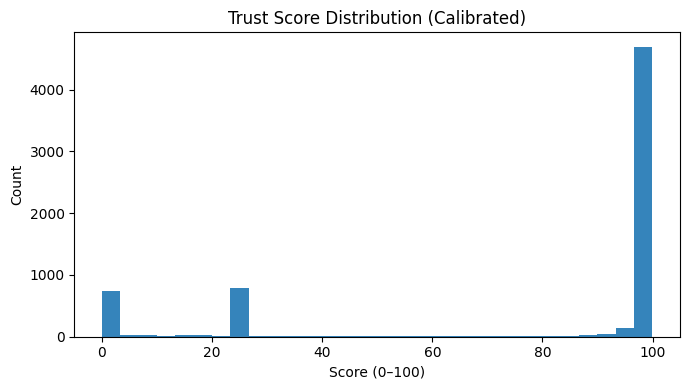

Saved: ../../figures/figure7_hist.png


In [5]:

# ==== Figure 7 style histogram ====
Path(FIG_HIST_PATH).parent.mkdir(parents=True, exist_ok=True)
plt.figure(figsize=(7,4))
plt.hist((y_prob*100).round(2), bins=30, alpha=0.9)
plt.title("Trust Score Distribution (Calibrated)")
plt.xlabel("Score (0–100)"); plt.ylabel("Count")
plt.tight_layout(); plt.savefig(FIG_HIST_PATH, dpi=200); plt.show()
print("Saved:", FIG_HIST_PATH)


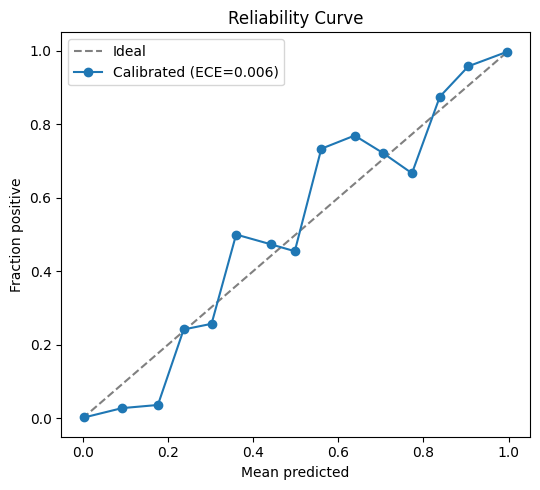

Saved: ../../figures/figure7_reliability.png


In [6]:

# ==== Reliability + ECE ====
def reliability_curve(y_true, y_prob, n_bins=15):
    bins = np.linspace(0,1,n_bins+1)
    ids = np.digitize(y_prob, bins) - 1
    xs, ys = [], []
    for b in range(n_bins):
        m = (ids==b)
        if m.sum()==0: continue
        xs.append(y_prob[m].mean())
        ys.append(y_true[m].mean())
    return np.array(xs), np.array(ys)

def expected_calibration_error(y_true, y_prob, n_bins=15):
    bins = np.linspace(0,1,n_bins+1)
    ids = np.digitize(y_prob, bins) - 1
    ece = 0.0
    for b in range(n_bins):
        m = (ids==b)
        if m.sum()==0: continue
        ece += (m.mean()) * abs(y_true[m].mean() - y_prob[m].mean())
    return float(ece)

mp, fp = reliability_curve(yte.values, y_prob, n_bins=15)
ece = expected_calibration_error(yte.values, y_prob, n_bins=15)

Path(FIG_REL_PATH).parent.mkdir(parents=True, exist_ok=True)
plt.figure(figsize=(5.5,5))
plt.plot([0,1],[0,1],'--',color='gray', label='Ideal')
plt.plot(mp, fp, marker='o', label=f'Calibrated (ECE={ece:.3f})')
plt.title("Reliability Curve")
plt.xlabel("Mean predicted"); plt.ylabel("Fraction positive")
plt.legend(); plt.tight_layout(); plt.savefig(FIG_REL_PATH, dpi=200); plt.show()
print("Saved:", FIG_REL_PATH)
